##### Copyright 2025 Google LLC.

In [1]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Day 2 - Classifying embeddings with Keras and the Gemini API

## Overview

Welcome back to the Kaggle 5-day Generative AI course. In this notebook, you'll learn to use the embeddings produced by the Gemini API to train a model that can classify newsgroup posts into the categories (the newsgroup itself) from the post contents.

This technique uses the Gemini API's embeddings as input, avoiding the need to train on text input directly, and as a result it is able to perform quite well using relatively few examples compared to training a text model from scratch.

## For help

**Common issues are covered in the [FAQ and troubleshooting guide](https://www.kaggle.com/code/markishere/day-0-troubleshooting-and-faqs).**


In [2]:
!pip uninstall -qqy jupyterlab kfp 2>/dev/null  # Remove unused conflicting packages
!pip install -U -q "google-genai==1.7.0"

In [3]:
from google import genai
from google.genai import types

genai.__version__

'1.7.0'

### Set up your API key

To run the following cell, your API key must be stored it in a [Kaggle secret](https://www.kaggle.com/discussions/product-feedback/114053) named `GOOGLE_API_KEY`.

If you don't already have an API key, you can grab one from [AI Studio](https://aistudio.google.com/app/apikey). You can find [detailed instructions in the docs](https://ai.google.dev/gemini-api/docs/api-key).

To make the key available through Kaggle secrets, choose `Secrets` from the `Add-ons` menu and follow the instructions to add your key or enable it for this notebook.

In [4]:
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")

client = genai.Client(api_key=GOOGLE_API_KEY)

If you received an error response along the lines of `No user secrets exist for kernel id ...`, then you need to add your API key via `Add-ons`, `Secrets` **and** enable it.

![Screenshot of the checkbox to enable GOOGLE_API_KEY secret](https://storage.googleapis.com/kaggle-media/Images/5gdai_sc_3.png)
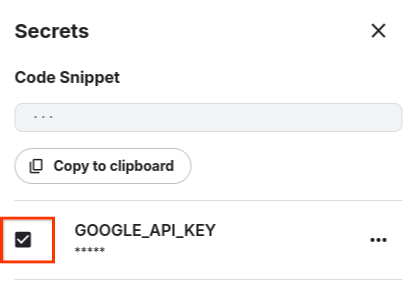

## Dataset

The [20 Newsgroups Text Dataset](https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html) contains 18,000 newsgroups posts on 20 topics divided into training and test sets. The split between the training and test datasets are based on messages posted before and after a specific date. For this tutorial, you will use sampled subsets of the training and test sets, and perform some processing using Pandas.

In [5]:
from sklearn.datasets import fetch_20newsgroups

newsgroups_train = fetch_20newsgroups(subset="train")
newsgroups_test = fetch_20newsgroups(subset="test")

# View list of class names for dataset
newsgroups_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

Here is an example of what a record from the training set looks like.

In [6]:
print(newsgroups_train.data[0])

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







In [7]:
newsgroups_train.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

In [8]:
len(newsgroups_train.target)

11314

Start by preprocessing the data for this tutorial in a Pandas dataframe. To remove any sensitive information like names and email addresses, you will take only the subject and body of each message. This is an optional step that transforms the input data into more generic text, rather than email posts, so that it will work in other contexts.

In [9]:
import email
import re

import pandas as pd


def preprocess_newsgroup_row(data):
    # Extract only the subject and body
    msg = email.message_from_string(data)
    text = f"{msg['Subject']}\n\n{msg.get_payload()}"
    # Strip any remaining email addresses
    text = re.sub(r"[\w\.-]+@[\w\.-]+", "", text)
    # Truncate each entry to 5,000 characters
    text = text[:5000]

    return text


def preprocess_newsgroup_data(newsgroup_dataset):
    # Put data points into dataframe
    df = pd.DataFrame(
        {"Text": newsgroup_dataset.data, "Label": newsgroup_dataset.target}
    )
    # Clean up the text
    df["Text"] = df["Text"].apply(preprocess_newsgroup_row)
    # Match label to target name index
    df["Class Name"] = df["Label"].map(lambda l: newsgroup_dataset.target_names[l])

    return df

In [10]:
# Apply preprocessing function to training and test datasets
df_train = preprocess_newsgroup_data(newsgroups_train)
df_test = preprocess_newsgroup_data(newsgroups_test)

df_train.head()

,Text,Label,Class Name
0,WHAT car is this!?\n\n I was wondering if anyo...,7,rec.autos
1,SI Clock Poll - Final Call\n\nA fair number of...,4,comp.sys.mac.hardware
2,"PB questions...\n\nwell folks, my mac plus fin...",4,comp.sys.mac.hardware
3,Re: Weitek P9000 ?\n\nRobert J.C. Kyanko () wr...,1,comp.graphics
4,Re: Shuttle Launch Question\n\nFrom article <>...,14,sci.space


Next, you will sample some of the data by taking 100 data points in the training dataset, and dropping a few of the categories to run through this tutorial. Choose the science categories to compare.

In [11]:
def sample_data(df, num_samples, classes_to_keep):
    # Sample rows, selecting num_samples of each Label.
    df = (
        df.groupby("Label")[df.columns]
        .apply(lambda x: x.sample(num_samples))
        .reset_index(drop=True)
    )

    df = df[df["Class Name"].str.contains(classes_to_keep)]

    # We have fewer categories now, so re-calibrate the label encoding.
    df["Class Name"] = df["Class Name"].astype("category")
    df["Encoded Label"] = df["Class Name"].cat.codes

    return df

In [12]:
TRAIN_NUM_SAMPLES = 100
TEST_NUM_SAMPLES = 25
# Class name should contain 'sci' to keep science categories.
# Try different labels from the data - see newsgroups_train.target_names
CLASSES_TO_KEEP = "sci"

df_train = sample_data(df_train, TRAIN_NUM_SAMPLES, CLASSES_TO_KEEP)
df_test = sample_data(df_test, TEST_NUM_SAMPLES, CLASSES_TO_KEEP)

In [13]:
df_train.value_counts("Class Name")

Class Name
sci.crypt          100
sci.electronics    100
sci.med            100
sci.space          100
Name: count, dtype: int64

In [14]:
df_test.value_counts("Class Name")

Class Name
sci.crypt          25
sci.electronics    25
sci.med            25
sci.space          25
Name: count, dtype: int64

## Create the embeddings

In this section, you will generate embeddings for each piece of text using the Gemini API embeddings endpoint. To learn more about embeddings, visit the [embeddings guide](https://ai.google.dev/docs/embeddings_guide).

**NOTE**: Embeddings are computed one at a time, so large sample sizes can take a long time!

### Task types

The `text-embedding-004` model supports a task type parameter that generates embeddings tailored for the specific task.

Task Type | Description
---       | ---
RETRIEVAL_QUERY	| Specifies the given text is a query in a search/retrieval setting.
RETRIEVAL_DOCUMENT | Specifies the given text is a document in a search/retrieval setting.
SEMANTIC_SIMILARITY	| Specifies the given text will be used for Semantic Textual Similarity (STS).
CLASSIFICATION	| Specifies that the embeddings will be used for classification.
CLUSTERING	| Specifies that the embeddings will be used for clustering.
FACT_VERIFICATION | Specifies that the given text will be used for fact verification.

For this example you will be performing classification.

In [15]:
from google.api_core import retry
import tqdm
from tqdm.rich import tqdm as tqdmr
import warnings

# Add tqdm to Pandas...
tqdmr.pandas()

# ...But suppress the experimental warning.
warnings.filterwarnings("ignore", category=tqdm.TqdmExperimentalWarning)

# Define a helper to retry when per-minute quota is reached.
is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

@retry.Retry(predicate=is_retriable, timeout=300.0)
def embed_fn(text: str) -> list[float]:
    # You will be performing classification, so set task_type accordingly.
    response = client.models.embed_content(
        model="models/text-embedding-004",
        contents=text,
        config=types.EmbedContentConfig(
            task_type="classification",
        ),
    )

    return response.embeddings[0].values


def create_embeddings(df):
    df["Embeddings"] = df["Text"].progress_apply(embed_fn)
    return df

This code is optimised for clarity, and is not particularly fast. It is left as an exercise for the reader to implement [batch](https://ai.google.dev/api/embeddings#method:-models.batchembedcontents) or parallel/asynchronous embedding generation. Running this step will take some time.

In [16]:
df_train = create_embeddings(df_train)
df_test = create_embeddings(df_test)

Output()

Output()

In [17]:
df_train.head()

,Text,Label,Class Name,Encoded Label,Embeddings
1100,"Re: Pgp, PEM, and RFC's (Was: Cryptography Pat...",11,sci.crypt,0,"[-0.009729882, 0.03217629, -0.035181765, 0.012..."
1101,Re: An Open Letter to Mr. Clinton\n\n (David S...,11,sci.crypt,0,"[0.004827171, 0.024748314, -0.037908744, 0.019..."
1102,Re: Source of random bits on a Unix workstatio...,11,sci.crypt,0,"[-0.03613194, 0.02853733, -0.03808971, 0.02628..."
1103,Re: Re-inventing Crypto Policy? An EFF Statem...,11,sci.crypt,0,"[0.00096365757, 0.021523995, -0.040752202, 0.0..."
1104,Re: Off the shelf cheap DES keyseach machine (...,11,sci.crypt,0,"[0.0036444229, 0.012952782, -0.036237206, 0.03..."


In [18]:
df_test.head()

,Text,Label,Class Name,Encoded Label,Embeddings
275,Basic Crypto Requirements\n\n\n In order to h...,11,sci.crypt,0,"[0.0020536133, 0.007420272, -0.04868103, 0.000..."
276,"Re: Key Registering Bodies\n\nIn article <>, \...",11,sci.crypt,0,"[-0.010012025, 0.02157417, -0.043625854, 0.032..."
277,Re: Tempest\n\nIn article <> (Kirill Shklovsk...,11,sci.crypt,0,"[-0.00821515, 0.011993041, -0.060611345, 0.020..."
278,Re: PGP Where to get it?\n\n>At the moment PGP...,11,sci.crypt,0,"[0.00048910547, 0.028028209, -0.051253777, 0.0..."
279,Re: Clipper considered harmful\n\n>Sternlight)...,11,sci.crypt,0,"[0.00566138, 0.025514375, -0.041760486, 0.0386..."


Batch Processing (max 100)

In [19]:
# Batch processing

@retry.Retry(predicate=is_retriable, timeout=300.0)
def embed_fn_batch(texts: list[str]) -> list[float]:
    """
    Embed a batch of texts (max 100 at a time).
    Returns a list of embeddings in the same order as input texts.
    """
    response = client.models.embed_content(
        model="models/text-embedding-004",
        contents=texts,
        config=types.EmbedContentConfig(
            task_type="classification",
        ),
    )
    # Extract all embedding values from the response
    return [embedding.values for embedding in response.embeddings]


def create_embeddings_batch(df, batch_size=100):
    """
    Create embeddings for all texts in dataframe using batched API calls.
    """
    all_embeddings = []
    texts = df["Text"].tolist()
    
    # Process in batches with progress bar
    for i in tqdmr(range(0, len(texts), batch_size), desc="Embedding batches"):
        batch = texts[i:i + batch_size]
        batch_embeddings = embed_fn_batch(batch)
        all_embeddings.extend(batch_embeddings)
    
    df["Embeddings"] = all_embeddings
    return df

In [20]:
df_train_new = create_embeddings_batch(df_train)
df_test_new = create_embeddings_batch(df_test)

Output()

Output()

In [21]:
df_train_new.head()

,Text,Label,Class Name,Encoded Label,Embeddings
1100,"Re: Pgp, PEM, and RFC's (Was: Cryptography Pat...",11,sci.crypt,0,"[-0.009729882, 0.03217629, -0.035181765, 0.012..."
1101,Re: An Open Letter to Mr. Clinton\n\n (David S...,11,sci.crypt,0,"[0.004827171, 0.024748314, -0.037908744, 0.019..."
1102,Re: Source of random bits on a Unix workstatio...,11,sci.crypt,0,"[-0.03613194, 0.02853733, -0.03808971, 0.02628..."
1103,Re: Re-inventing Crypto Policy? An EFF Statem...,11,sci.crypt,0,"[0.00096365757, 0.021523995, -0.040752202, 0.0..."
1104,Re: Off the shelf cheap DES keyseach machine (...,11,sci.crypt,0,"[0.0036444229, 0.012952782, -0.036237206, 0.03..."


In [22]:
df_test_new.head()

,Text,Label,Class Name,Encoded Label,Embeddings
275,Basic Crypto Requirements\n\n\n In order to h...,11,sci.crypt,0,"[0.0020536133, 0.007420272, -0.04868103, 0.000..."
276,"Re: Key Registering Bodies\n\nIn article <>, \...",11,sci.crypt,0,"[-0.010012025, 0.02157417, -0.043625854, 0.032..."
277,Re: Tempest\n\nIn article <> (Kirill Shklovsk...,11,sci.crypt,0,"[-0.00821515, 0.011993041, -0.060611345, 0.020..."
278,Re: PGP Where to get it?\n\n>At the moment PGP...,11,sci.crypt,0,"[0.00048910547, 0.028028209, -0.051253777, 0.0..."
279,Re: Clipper considered harmful\n\n>Sternlight)...,11,sci.crypt,0,"[0.00566138, 0.025514375, -0.041760486, 0.0386..."


## Build a classification model

Here you will define a simple model that accepts the raw embedding data as input, has one hidden layer, and an output layer specifying the class probabilities. The prediction will correspond to the probability of a piece of text being a particular class of news.

When you run the model, Keras will take care of details like shuffling the data points, calculating metrics and other ML boilerplate.

In [23]:
import keras
from keras import layers


def build_classification_model(input_size: int, num_classes: int) -> keras.Model:
    return keras.Sequential(
        [
            layers.Input([input_size], name="embedding_inputs"),
            layers.Dense(input_size, activation="relu", name="hidden"),
            layers.Dense(num_classes, activation="softmax", name="output_probs"),
        ]
    )

In [24]:
# Derive the embedding size from observing the data. The embedding size can also be specified
# with the `output_dimensionality` parameter to `embed_content` if you need to reduce it.
embedding_size = len(df_train["Embeddings"].iloc[0])

classifier = build_classification_model(
    embedding_size, len(df_train["Class Name"].unique())
)
classifier.summary()

classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["accuracy"],
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden (Dense)                  │ (None, 768)            │       590,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_probs (Dense)            │ (None, 4)              │         3,076 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 593,668 (2.26 MB)

 Trainable params: 593,668 (2.26 MB)

 Non-trainable params: 0 (0.00 B)

## Train the model

Finally, you can train your model. This code uses early stopping to exit the training loop once the loss value stabilises, so the number of epoch loops executed may differ from the specified value.

In [25]:
import numpy as np


NUM_EPOCHS = 20
BATCH_SIZE = 32

# Split the x and y components of the train and validation subsets.
y_train = df_train["Encoded Label"]
x_train = np.stack(df_train["Embeddings"])
y_val = df_test["Encoded Label"]
x_val = np.stack(df_test["Embeddings"])

# Specify that it's OK to stop early if accuracy stabilises.
early_stop = keras.callbacks.EarlyStopping(monitor="accuracy", patience=3)

# Train the model for the desired number of epochs.
history = classifier.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_val, y_val),
    callbacks=[early_stop],
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
)

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.3597 - loss: 1.3607 - val_accuracy: 0.4000 - val_loss: 1.2755
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7367 - loss: 1.1936 - val_accuracy: 0.6700 - val_loss: 1.1381
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6328 - loss: 1.0505 - val_accuracy: 0.6600 - val_loss: 1.0321
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8674 - loss: 0.8646 - val_accuracy: 0.8200 - val_loss: 0.8571
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9180 - loss: 0.6870 - val_accuracy: 0.8400 - val_loss: 0.7314
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9435 - loss: 0.5493 - val_accuracy: 0.7600 - val_loss: 0.6498
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9171 - loss: 0.4477 - val_accuracy: 0.8400 - val_loss: 0.5438
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9605 - loss: 0.3435 - val_accuracy: 0.8700 - val_loss

## Evaluate model performance

Use Keras <a href="https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate"><code>Model.evaluate</code></a> to calculate the loss and accuracy on the test dataset.

In [26]:
classifier.evaluate(x=x_val, y=y_val, return_dict=True)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9013 - loss: 0.2806 


{'accuracy': 0.9200000166893005, 'loss': 0.24378672242164612}

To learn more about training models with Keras, including how to visualise the model training metrics, read [Training & evaluation with built-in methods](https://www.tensorflow.org/guide/keras/training_with_built_in_methods).

## Try a custom prediction

Now that you have a trained model with good evaluation metrics, you can try to make a prediction with new, hand-written data. Use the provided example or try your own data to see how the model performs.

In [27]:
def make_prediction(text: str) -> list[float]:
    """Infer categories from the provided text."""
    # Remember that the model takes embeddings as input, so calculate them first.
    embedded = embed_fn(new_text)

    # And recall that the input must be batched, so here they are wrapped as a
    # list to provide a batch of 1.
    inp = np.array([embedded])

    # And un-batched here.
    [result] = classifier.predict(inp)
    return result

In [28]:
# This example avoids any space-specific terminology to see if the model avoids
# biases towards specific jargon.
new_text = """
First-timer looking to get out of here.

Hi, I'm writing about my interest in travelling to the outer limits!

What kind of craft can I buy? What is easiest to access from this 3rd rock?

Let me know how to do that please.
"""

result = make_prediction(new_text)

for idx, category in enumerate(df_test["Class Name"].cat.categories):
    print(f"{category}: {result[idx] * 100:0.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
sci.crypt: 0.02%
sci.electronics: 0.32%
sci.med: 0.02%
sci.space: 99.65%


In [29]:
result

array([1.5257017e-04, 3.1917498e-03, 1.9727672e-04, 9.9645835e-01],
      dtype=float32)

In [30]:
sorted_result = sorted(enumerate(result), key=lambda x:-x[1])
sorted_result

[(3, 0.99645835), (1, 0.0031917498), (2, 0.00019727672), (0, 0.00015257017)]

In [31]:
df_test["Class Name"].cat.categories

Index(['sci.crypt', 'sci.electronics', 'sci.med', 'sci.space'], dtype='object')

In [32]:
# sort in descending order of prediction scores

categories = df_test["Class Name"].cat.categories

for idx, score in sorted_result:
    print(f"{categories[idx]}: {score * 100:0.2f}%")

sci.space: 99.65%
sci.electronics: 0.32%
sci.med: 0.02%
sci.crypt: 0.02%


## Further reading

To explore training custom models with Keras further, check out the [Keras guides](https://keras.io/guides/).

*- [Mark McD](https://linktr.ee/markmcd)*